# Installing & Importing Libraries

In [2]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

In [3]:
from tensorflow.python.client import device_lib

print(" GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

 GPUs Available:  []
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4638701373569735741
xla_global_id: -1
]


In [6]:
class_dict_df = pd.read_csv('./input/class_dict.csv', index_col=False, skipinitialspace=True)
class_dict_df

name    r    g    b
0       water  226  169   41
1        land  132   41  246
2        road  110  193  228
3    building   60   16  152
4  vegetation  254  221   58
5   unlabeled  155  155  155

In [8]:
label_names= list(class_dict_df.name)
label_codes = []
r= np.asarray(class_dict_df.r)
g= np.asarray(class_dict_df.g)
b= np.asarray(class_dict_df.b)

for i in range(len(class_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))
    
label_codes, label_names

([(226, 169, 41),
  (132, 41, 246),
  (110, 193, 228),
  (60, 16, 152),
  (254, 221, 58),
  (155, 155, 155)],
 ['water', 'land', 'road', 'building', 'vegetation', 'unlabeled'])

# Create Useful Label & Code Conversion Dictionaries

These will be used for:

* One hot encoding the mask labels for model training
* Decoding the predicted labels for interpretation and visualization

In [9]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [10]:
id2code

{0: (226, 169, 41),
 1: (132, 41, 246),
 2: (110, 193, 228),
 3: (60, 16, 152),
 4: (254, 221, 58),
 5: (155, 155, 155)}

In [11]:
id2name

{0: 'water',
 1: 'land',
 2: 'road',
 3: 'building',
 4: 'vegetation',
 5: 'unlabeled'}

# Define Functions for One Hot Encoding RGB Labels & Decoding Encoded Predictions

In [12]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

# Creating Custom Image Data Generators
## Defining Data Generators

In [13]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

# Custom Image Data Generators for Creating Batches of Frames and Masks

In [31]:
def TrainAugmentGenerator(train_images_dir, train_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            train_images_dir - train images directory
            train_masks_dir - train masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    train_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    train_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    while True:
        X1i = next(train_image_generator)
        X2i = next(train_mask_generator)
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(val_images_dir, val_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            val_images_dir - validation images directory
            val_masks_dir - validation masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    val_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    val_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    while True:
        X1i = next(val_image_generator)
        X2i = next(val_mask_generator)
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

# Model

In [15]:
train_images = "./train/images"
train_masks = "./train/masks"
test_images = "./test/images"
test_masks = "./test/masks"

In [26]:
batch_size = 16
num_train_samples = len(np.sort(os.listdir(train_images)))
num_test_samples = len(np.sort(os.listdir(test_images)))
steps_per_epoch = int(np.ceil(float(num_train_samples) / float(batch_size)))
print('steps_per_epoch: ', steps_per_epoch)
test_steps = int(np.ceil(float(4 * num_test_samples) / float(batch_size)))
print('validation_steps: ', test_steps)

steps_per_epoch:  32
validation_steps:  36


## InceptionResNetV2 UNet

In [39]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_layer").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(6, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model

In [ ]:
K.clear_session()

def dice_coef(y_true, y_pred):
    y_true_f = K.cast(y_true, 'float32')
    y_pred_f = K.cast(y_pred, 'float32')
    return (2. * K.sum(y_true_f * y_pred_f) + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

In [41]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = 'InceptionResNetV2-UNet.keras',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [42]:
history = model.fit(
    TrainAugmentGenerator(train_images_dir = "./train", train_masks_dir = "./train", target_size = (512, 512)), 
    steps_per_epoch=steps_per_epoch,
    validation_data = ValAugmentGenerator(val_images_dir = "./test", val_masks_dir = "./test", target_size = (512, 512)), 
    validation_steps = test_steps, 
    epochs = 50,
    callbacks=callbacks,
    verbose=1
)

Found 1012 images belonging to 2 classes.


Found 1012 images belonging to 2 classes.
(8, 512, 512, 3) (8, 512, 512, 6)

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50
(8, 512, 512, 3) (8, 512, 512, 6)
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2:29:26 289s/step - accuracy: 0.0885 - dice_coef: 0.1219 - loss: 1.6879(8, 512, 512, 3) (8, 512, 512, 6)
 2/32 ━━━━━━━━━━━━━━━━━━━━ 1:12:02 144s/step - accuracy: 0.0803 - dice_coef: 0.0999 - loss: 1.3428(8, 512, 512, 3) (8, 512, 512, 6)


In [23]:
df_result = pd.DataFrame(history.history)
df_result

loss  dice_coef  accuracy  val_loss  val_dice_coef  val_accuracy  \
0   1.194196   0.410463  0.593694  1.539598       0.218672      0.710757   
1   0.904097   0.544565  0.703085  1.265158       0.301777      0.727709   
2   0.764639   0.607730  0.753080  0.999804       0.417060      0.754785   
3   0.678071   0.646499  0.780523  0.873978       0.477698      0.788288   
4   0.579720   0.695616  0.818133  0.735966       0.554353      0.803350   
5   0.569138   0.701144  0.817656  0.718938       0.583523      0.785305   
6   0.497732   0.735823  0.842199  0.615667       0.658263      0.796857   
7   0.519239   0.726397  0.836170  0.753924       0.604373      0.722596   
8   0.458315   0.751661  0.854142  0.549499       0.709090      0.815532   
9   0.447860   0.762622  0.857885  0.515742       0.728271      0.826542   
10  0.420234   0.770715  0.864475  0.489432       0.742384      0.834593   
11  0.423950   0.775435  0.863609  0.517996       0.739131      0.823771   
12  0.388729   0.788291  0.873878  0.504511       0.747302      0.825845   
13  0.364350   0.800164  0.882077  0.445335       0.774097      0.849308   
14  0.369625   0.798127  0.878452  0.496844       0.768585      0.832760   
15  0.372735   0.799708  0.881899  0.505284       0.757165      0.824699   
16  0.351550   0.806939  0.885695  0.468696       0.774555      0.841556   
17  0.355415   0.804621  0.883109  0.473040       0.781433      0.838347   
18  0.349871   0.809474  0.887468  0.467068       0.785297      0.843686   
19  0.354732   0.806811  0.884011  0.478444       0.774992      0.837502   
20  0.291920   0.834552  0.904765  0.464631       0.785629      0.844892   
21  0.328073   0.819569  0.892707  0.433813       0.806467      0.855737   
22  0.328541   0.820127  0.892638  0.456502       0.786172      0.844643   
23  0.311297   0.825456  0.897536  0.464056       0.785745      0.841255   
24  0.294597   0.833819  0.903414  0.456107       0.790948      0.845937   
25  0.295536   0.834523  0.902316  0.493487       0.771461      0.831527   
26  0.289910   0.835634  0.906473  0.475071       0.780142      0.837774   
27  0.296176   0.833668  0.900665  0.452324       0.787664      0.846614   
28  0.270267   0.845367  0.910321  0.461164       0.795121      0.845221   
29  0.269567   0.848640  0.910672  0.477861       0.784489      0.838787   
30  0.280190   0.840387  0.905949  0.457235       0.794417      0.846852   
31  0.260824   0.852339  0.913146  0.473859       0.785465      0.839232   
32  0.253124   0.856772  0.914376  0.463726       0.797343      0.844188   
33  0.251770   0.855620  0.915929  0.426756       0.811163      0.857305   
34  0.242926   0.860980  0.919285  0.484542       0.793415      0.838133   
35  0.268287   0.849845  0.908729  0.502545       0.788448      0.834370   
36  0.235457   0.863013  0.921105  0.486014       0.797205      0.840380   
37  0.248429   0.857278  0.917847  0.508562       0.782393      0.830271   
38  0.250644   0.857256  0.916506  0.480670       0.797652      0.841274   
39  0.257628   0.855552  0.913859  0.435778       0.815468      0.856362   
40  0.248678   0.856435  0.917410  0.487045       0.797628      0.838330   
41  0.228565   0.868372  0.922338  0.477322       0.803855      0.845259   
42  0.240307   0.862962  0.918764  0.502747       0.798108      0.840876   
43  0.239253   0.860264  0.919620  0.506082       0.784626      0.831992   
44  0.228945   0.868475  0.923513  0.488423       0.800173      0.839796   
45  0.233200   0.867031  0.921820  0.481474       0.801083      0.843414   

          lr  
0   0.000100  
1   0.000096  
2   0.000093  
3   0.000089  
4   0.000086  
5   0.000083  
6   0.000079  
7   0.000076  
8   0.000074  
9   0.000071  
10  0.000068  
11  0.000066  
12  0.000063  
13  0.000061  
14  0.000058  
15  0.000056  
16  0.000054  
17  0.000052  
18  0.000050  
19  0.000048  
20  0.000046  
21  0.000045  
22  0.000043  
23  0.000041  
24  0.000040  
25  0.000038  
26  0.000037  
27  0.000035  


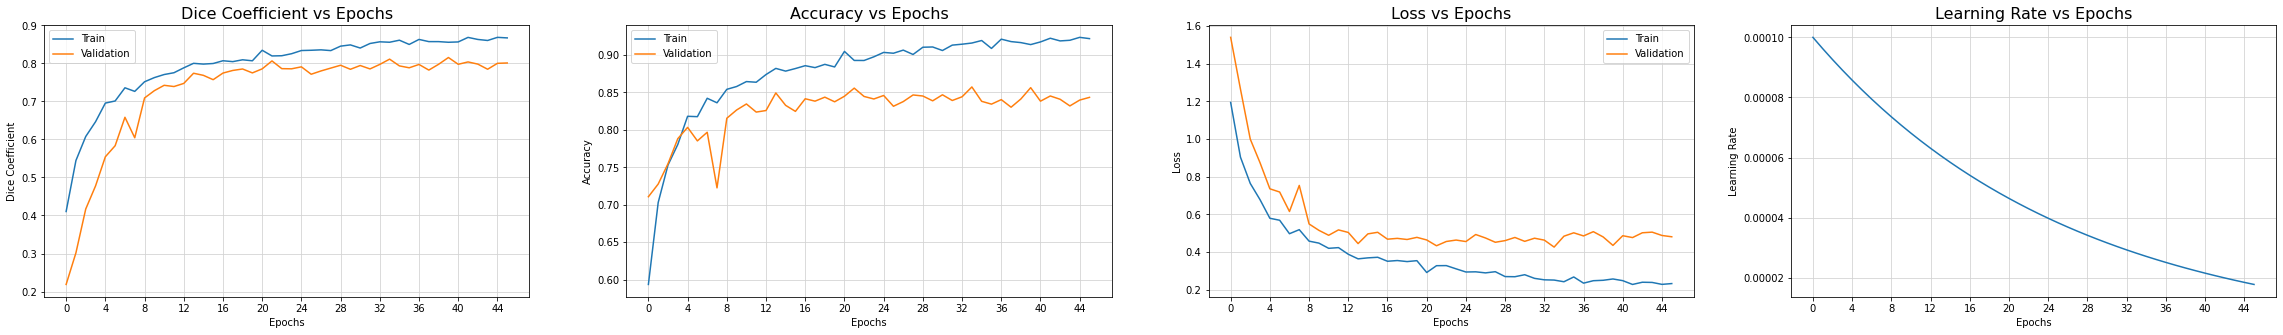

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(40, 5))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss', 'Learning Rate']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss', 'lr']): 
    if met != 'lr':
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].legend(['Train', 'Validation'])
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    else:
        ax[i].plot(history.history[met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        
plt.savefig('model_metrics_plot.png', facecolor= 'w',transparent= False, bbox_inches= 'tight', dpi= 150)

In [25]:
model.load_weights("./InceptionResNetV2-UNet.h5")

In [26]:
testing_gen = ValAugmentGenerator(val_images_dir = val_images, val_masks_dir = val_masks, target_size = (512, 512))

In [27]:
!mkdir predictions

Found 16 images belonging to 1 classes.
Found 16 images belonging to 1 classes.


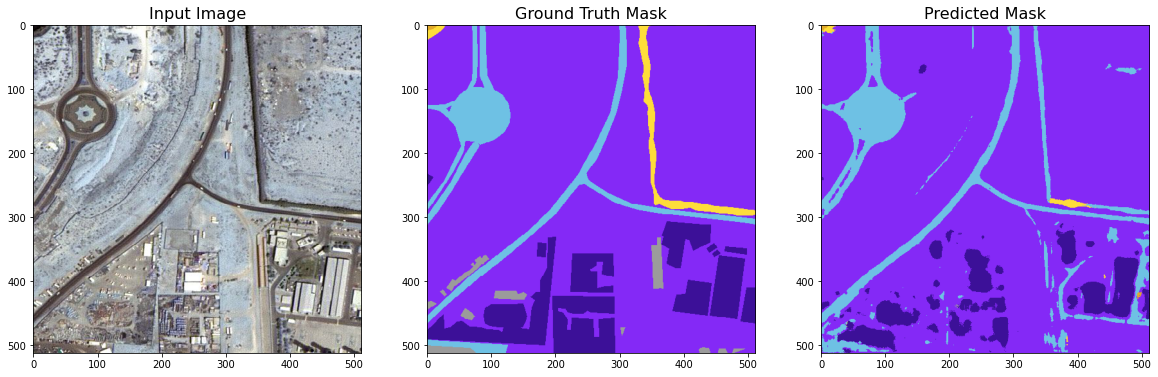

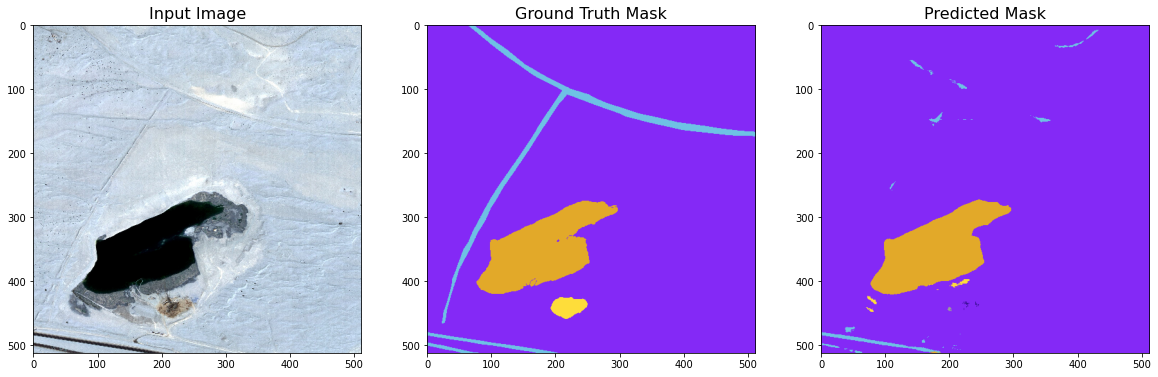

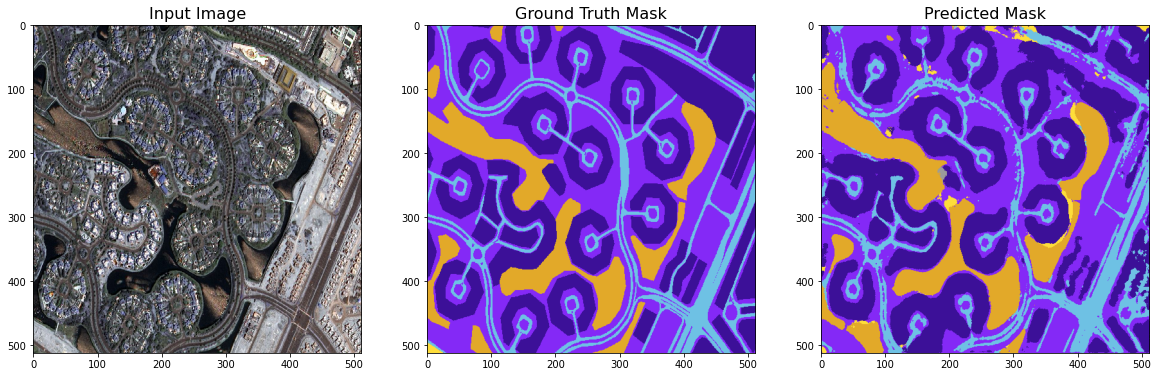

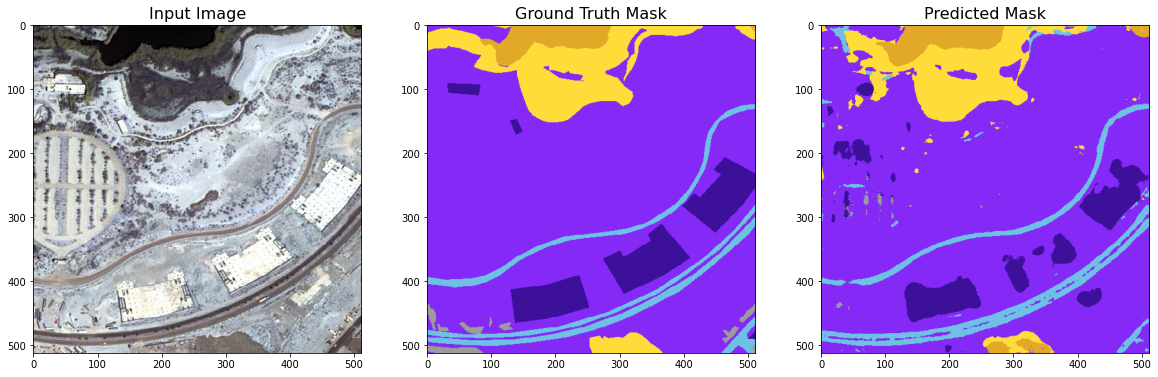

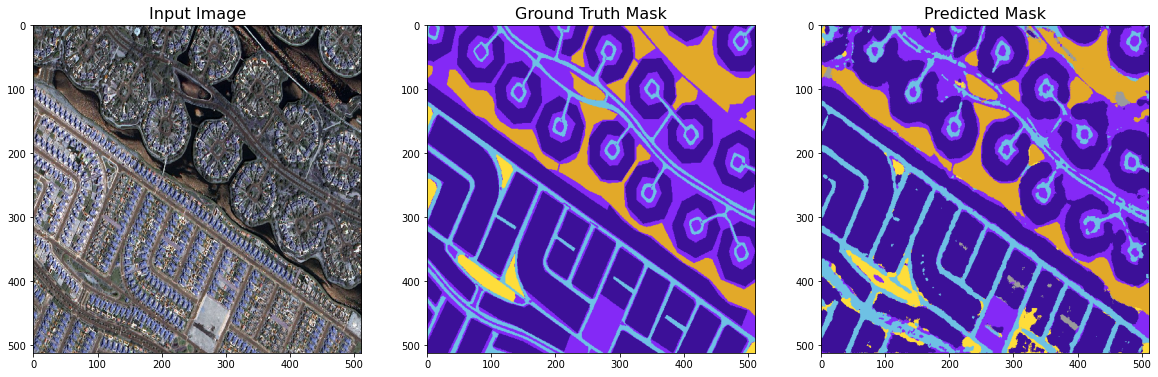

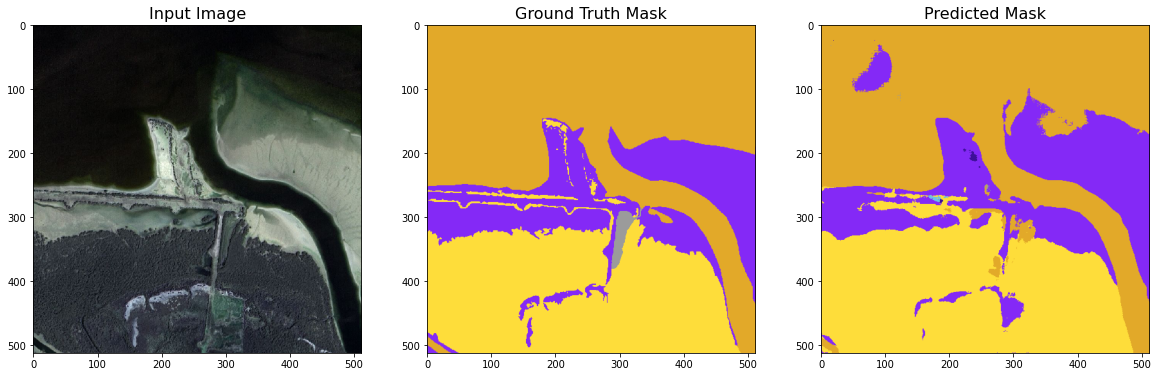

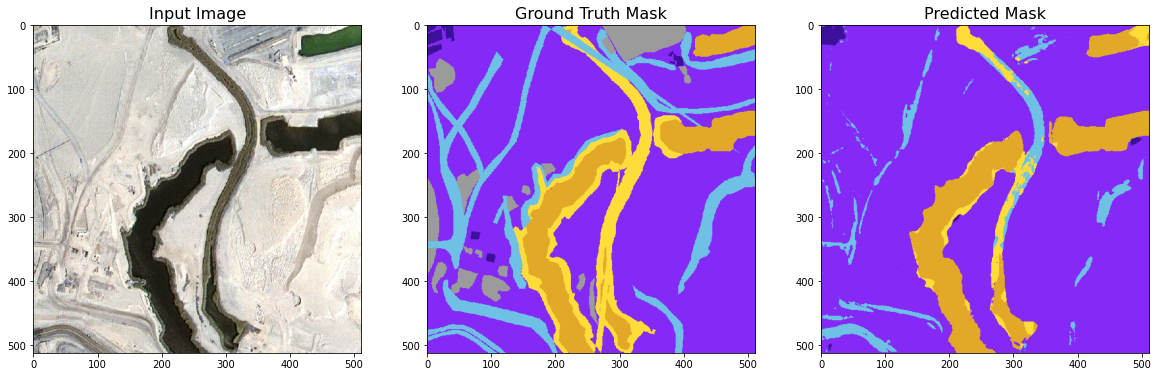

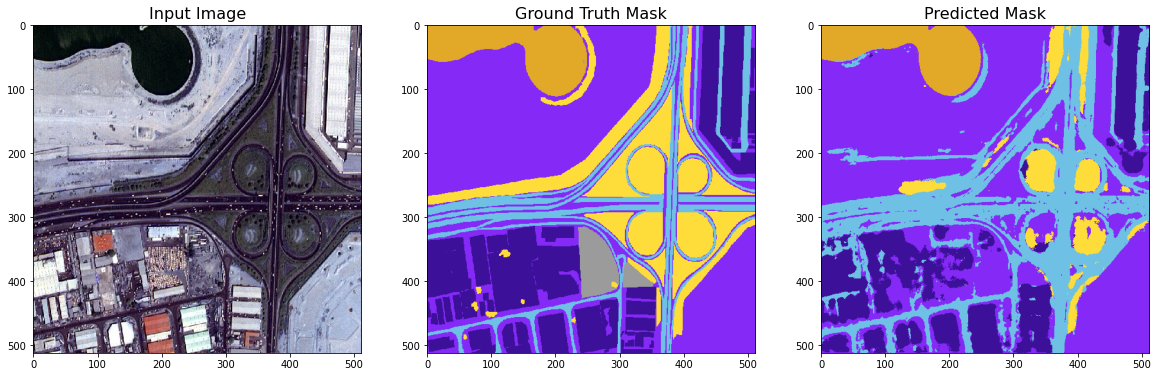

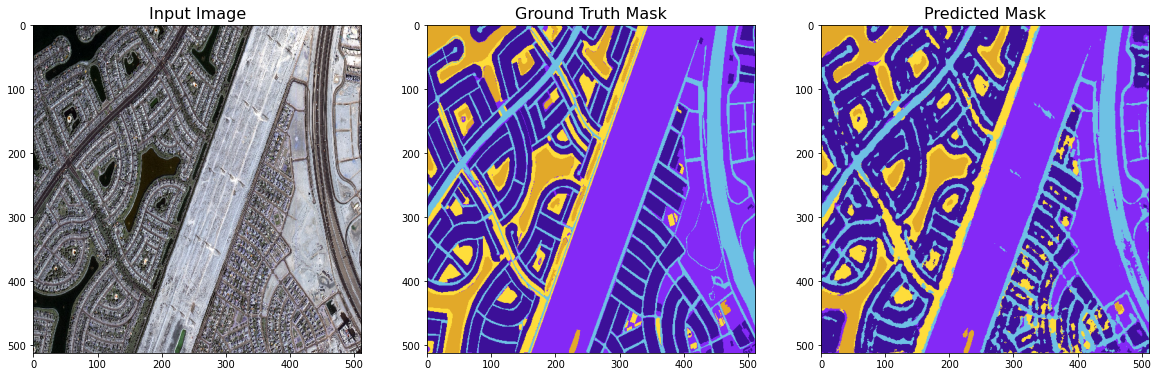

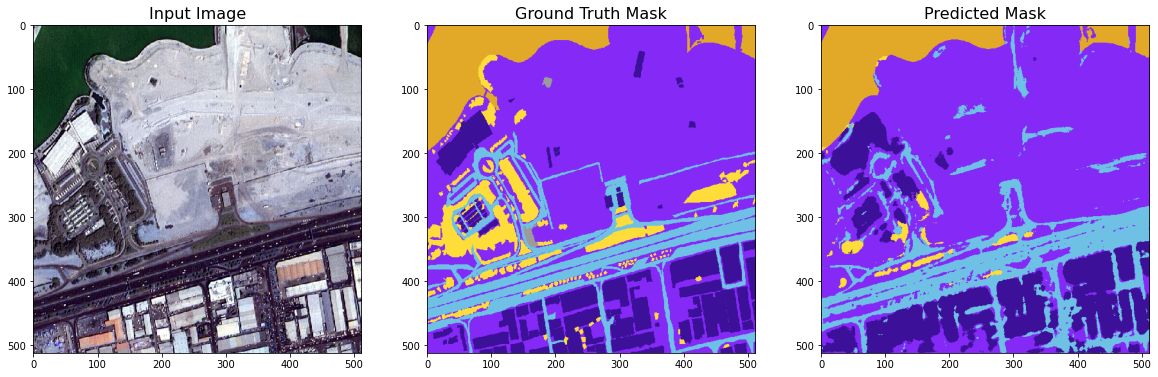

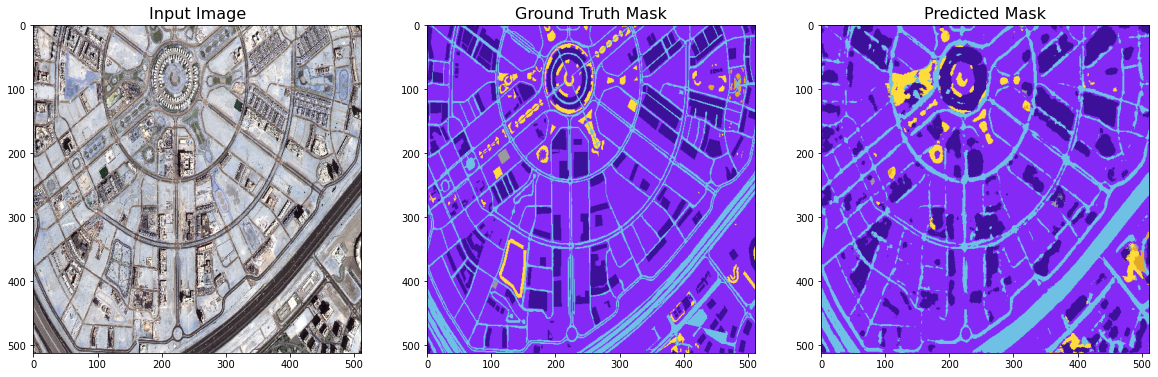

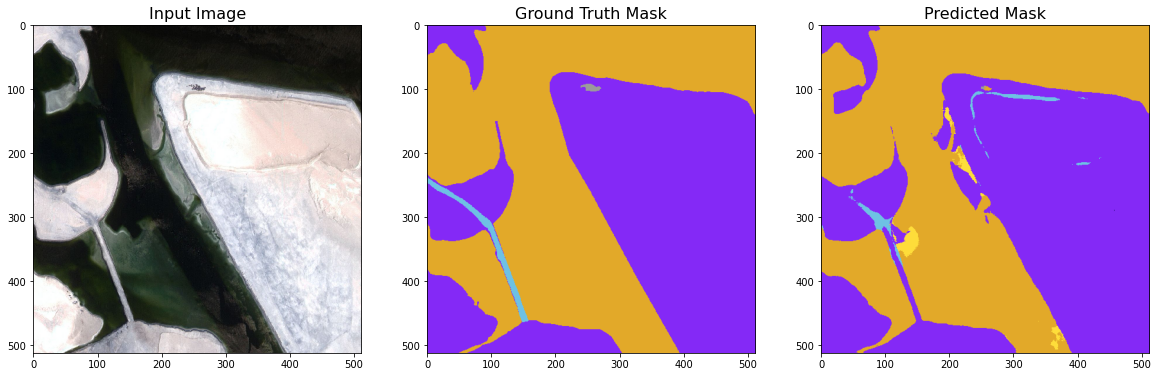

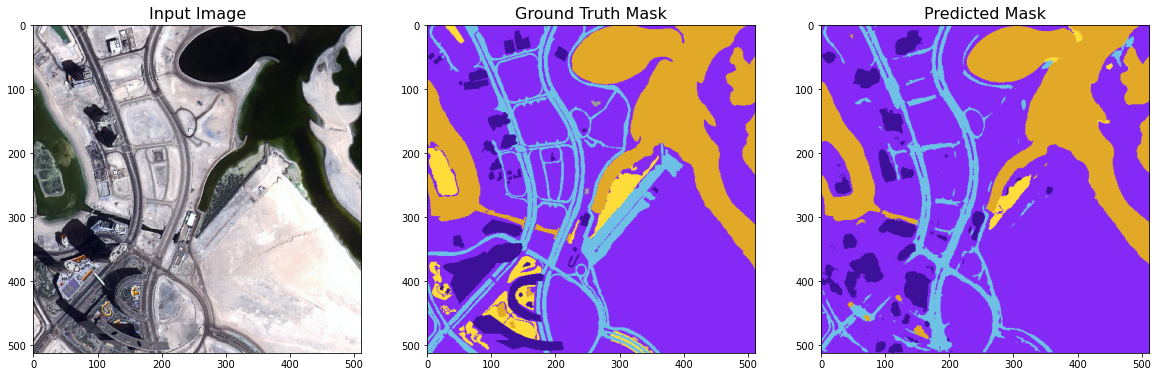

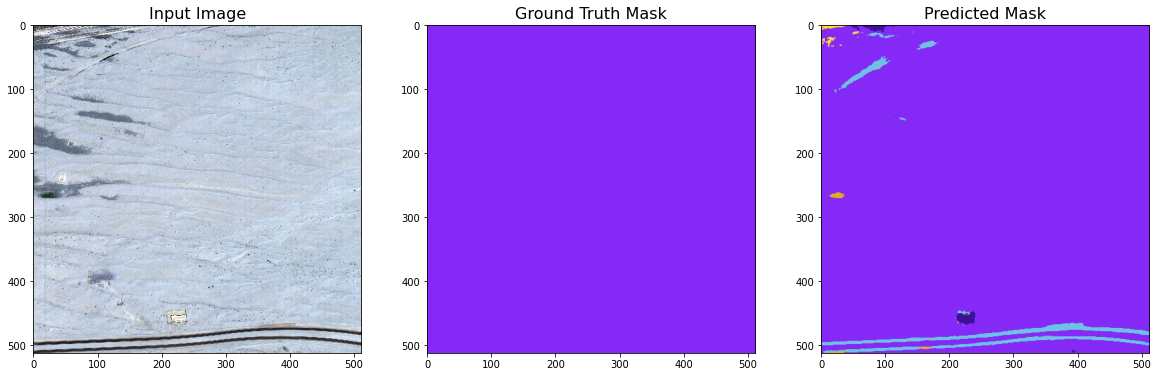

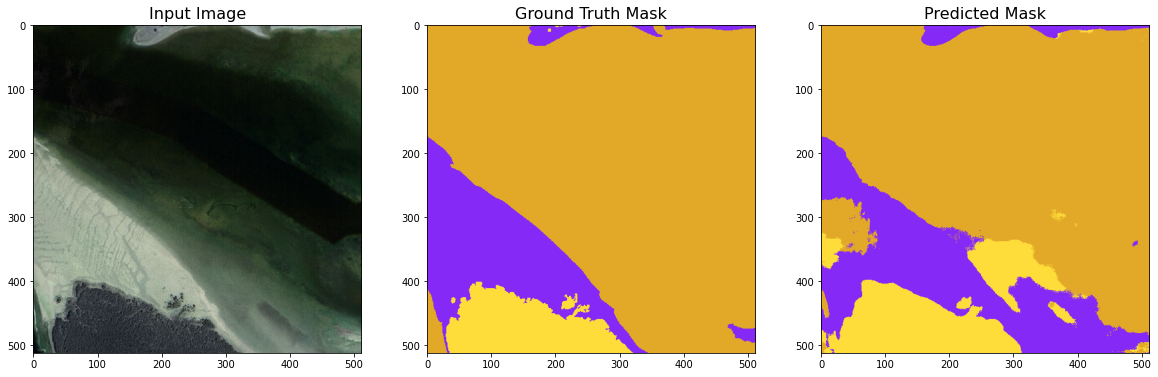

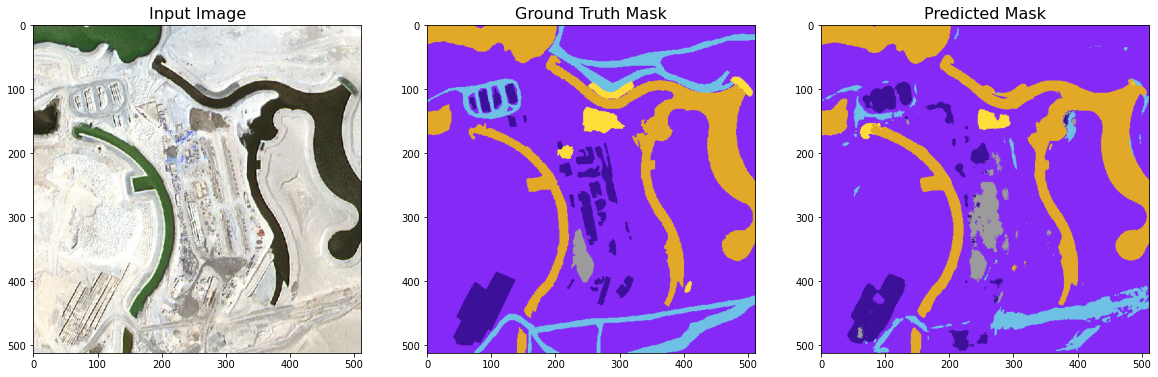

In [28]:
count = 0
for i in range(2):
    batch_img,batch_mask = next(testing_gen)
    pred_all= model.predict(batch_img)
    np.shape(pred_all)
    
    for j in range(0,np.shape(pred_all)[0]):
        count += 1
        fig = plt.figure(figsize=(20,8))

        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(batch_img[j])
        ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax1.grid(False)

        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax2.imshow(onehot_to_rgb(batch_mask[j],id2code))
        ax2.grid(False)

        ax3 = fig.add_subplot(1,3,3)
        ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax3.imshow(onehot_to_rgb(pred_all[j],id2code))
        ax3.grid(False)

        plt.savefig('./predictions/prediction_{}.png'.format(count), facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 200)
        plt.show()

In [29]:
!zip -r predictions.zip "./predictions"

  adding: predictions/ (stored 0%)
  adding: predictions/prediction_2.png (deflated 2%)
  adding: predictions/prediction_16.png (deflated 1%)
  adding: predictions/prediction_13.png (deflated 1%)
  adding: predictions/prediction_12.png (deflated 2%)
  adding: predictions/prediction_9.png (deflated 0%)
  adding: predictions/prediction_15.png (deflated 2%)
  adding: predictions/prediction_8.png (deflated 1%)
  adding: predictions/prediction_4.png (deflated 1%)
  adding: predictions/prediction_3.png (deflated 0%)
  adding: predictions/prediction_5.png (deflated 0%)
  adding: predictions/prediction_7.png (deflated 1%)
  adding: predictions/prediction_14.png (deflated 2%)
  adding: predictions/prediction_11.png (deflated 0%)
  adding: predictions/prediction_10.png (deflated 1%)
  adding: predictions/prediction_6.png (deflated 2%)
  adding: predictions/prediction_1.png (deflated 1%)


In [30]:
!rm -rf './predictions/'